In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

input_size = 224  
batch_size = 16

train_dir = 'dogs-vs-cats/train'
test_dir = 'dogs-vs-cats/test'    

def create_dataframe_from_directory(directory):
    filenames = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            filenames.append(os.path.join(directory, filename))
            labels.append(filename.split('.')[0])
    return pd.DataFrame({'filename': filenames, 'class': labels})

train_df = create_dataframe_from_directory(train_dir)

train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_df['filename'],
    train_df['class'],
    test_size=0.2,
    stratify=train_df['class'],
    random_state=42
)

train_data = pd.DataFrame({'filename': train_files, 'class': train_labels})
valid_data = pd.DataFrame({'filename': valid_files, 'class': valid_labels})
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
test_data = pd.DataFrame({'filename': test_files})

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)

valid_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col='class',
    target_size=(input_size, input_size),
    batch_size=batch_size,
    class_mode='binary',  
    shuffle=True
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='filename',
    y_col='class',
    target_size=(input_size, input_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename',
    target_size=(input_size, input_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

print("Class indices:", train_generator.class_indices)
print("Training samples:", train_generator.n)
print("Validation samples:", valid_generator.n)
print("Test samples:", test_generator.n)

2025-02-23 15:12:04.350748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 15:12:04.466214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 15:12:04.516987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 15:12:04.529053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 15:12:04.619228: I tensorflow/core/platform/cpu_feature_guar

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.
Class indices: {'cat': 0, 'dog': 1}
Training samples: 20000
Validation samples: 5000
Test samples: 12500


In [3]:
train_data

,filename,class
14956,dogs-vs-cats/train/dog.10231.jpg,dog
10039,dogs-vs-cats/train/cat.1903.jpg,cat
24484,dogs-vs-cats/train/dog.672.jpg,dog
2518,dogs-vs-cats/train/dog.9395.jpg,dog
15972,dogs-vs-cats/train/dog.3761.jpg,dog
...,...,...
20147,dogs-vs-cats/train/dog.6090.jpg,dog
15913,dogs-vs-cats/train/dog.300.jpg,dog
20946,dogs-vs-cats/train/cat.4677.jpg,cat
10417,dogs-vs-cats/train/cat.6336.jpg,cat


### Visualize

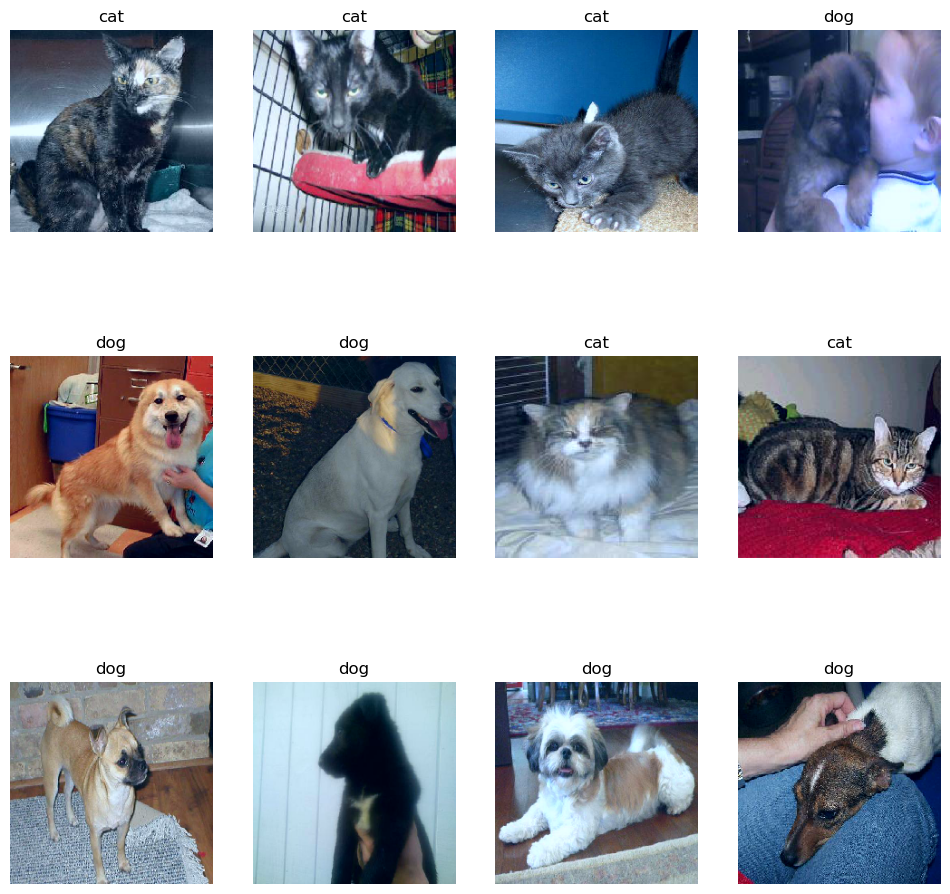

In [4]:
train_images, train_labels = next(train_generator)  
class_labels = list(train_generator.class_indices.keys())

def deprocess_vgg(image):
    image = image.copy()
    image = image[..., ::-1] 
    image[..., 0] += 103.939 
    image[..., 1] += 116.779  
    image[..., 2] += 123.68   
    image = np.clip(image, 0, 255).astype(np.uint8) 
    return image

plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(3, 4, i+1)  
    plt.imshow(deprocess_vgg(train_images[i]))
    plt.axis('off') 
    label_index = int(train_labels[i]) 
    label = class_labels[label_index]   
    plt.title(label)

plt.show()

In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('dog_cat_classifier_vgg16.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=2)
]

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=callbacks,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

I0000 00:00:1740316690.275189  122481 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740316690.420715  122481 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740316690.422083  122481 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740316690.425515  122481 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
model.load_weights('dog_cat_classifier_vgg16.keras')

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
# Fine-tuning 
base_model.trainable = True  

# freeze the first 15 layers of VGG16
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('dog_cat_classifier_tuned_vgg16.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=2)
]

history_fine = model.fit(
    train_generator,
    epochs=5, 
    validation_data=valid_generator,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(valid_generator)
print(f'valid accuracy: {test_acc:.4f}')
test_predictions = model.predict(test_generator)
print(test_predictions)

Epoch 1/5


/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740307297.386885   19778 service.cc:146] XLA service 0x7f5094015f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740307297.386916   19778 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-02-23 12:41:37.447452: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-23 12:41:37.840072: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN v

   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:55 93ms/step - accuracy: 1.0000 - loss: 0.0059  

I0000 00:00:1740307307.182098   19778 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 118ms/step - accuracy: 0.9782 - loss: 0.0594 - val_accuracy: 0.9848 - val_loss: 0.0450 - learning_rate: 1.0000e-05
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.9872 - loss: 0.0352 - val_accuracy: 0.9846 - val_loss: 0.0437 - learning_rate: 1.0000e-05
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.9924 - loss: 0.0248 - val_accuracy: 0.9806 - val_loss: 0.0560 - learning_rate: 1.0000e-05
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.9933 - loss: 0.0192 - val_accuracy: 0.9868 - val_loss: 0.0383 - learning_rate: 1.0000e-05
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.9971 - loss: 0.0115 - val_accuracy: 0.9840 - val_loss: 0.0587 - learning_rate: 1.0000e-05
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9851 - loss: 0.0522
valid accuracy: 0.9868
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step
[[1.3443129e-03]
 [4.7578946e-05]
 [9.9992406e-01]
 ...
 [9.9

In [8]:
model.load_weights('dog_cat_classifier_tuned_vgg16.keras')

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


I0000 00:00:1740316805.744782  136048 service.cc:146] XLA service 0x7f09ec0056d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740316805.744810  136048 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-02-23 15:20:05.764736: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-23 15:20:05.867006: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1740316812.755209  136048 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


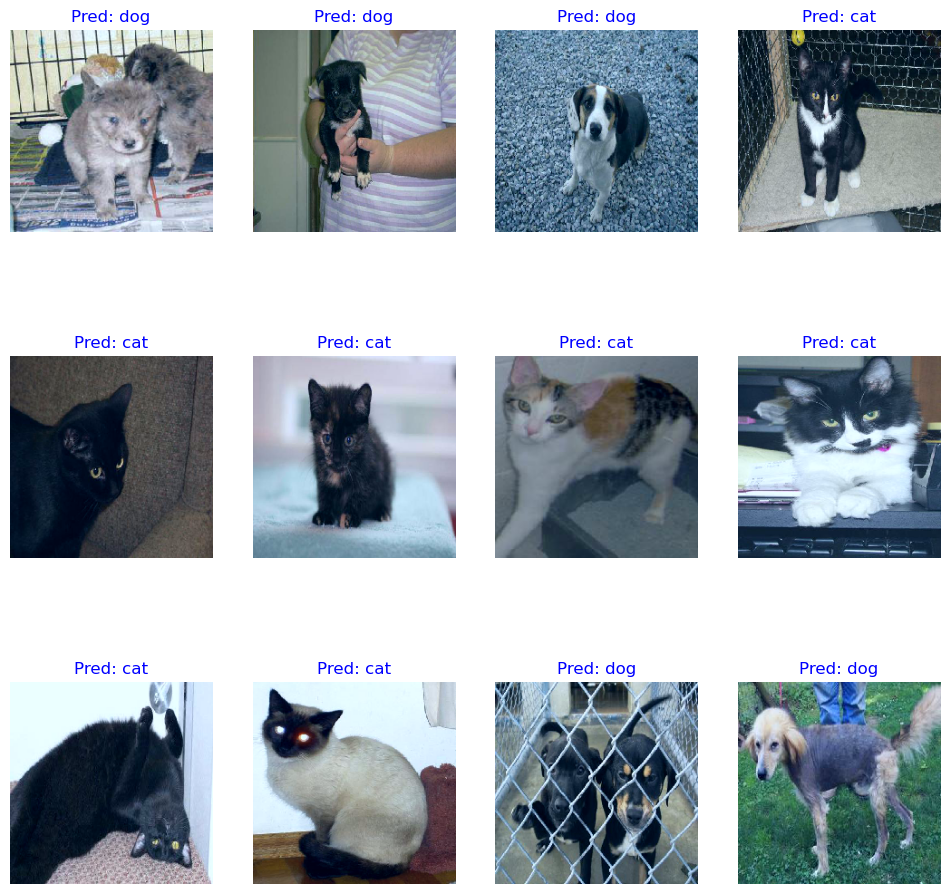

In [9]:
test_images = next(test_generator)
pred_probs = model.predict(test_images)
pred_labels = (pred_probs > 0.5).astype(int).flatten() 
class_labels = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(12, 12))
for i in range(12): 
    plt.subplot(3, 4, i+1)
    plt.imshow(deprocess_vgg(test_images[i]).astype("uint8"))
    plt.axis('off')

    pred_class = class_labels[pred_labels[i]]

    plt.title(f"Pred: {pred_class}", color="blue") 

plt.show()